<a href="https://colab.research.google.com/github/riskingsun/analytics/blob/master/FirstFineTuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<Axes: >

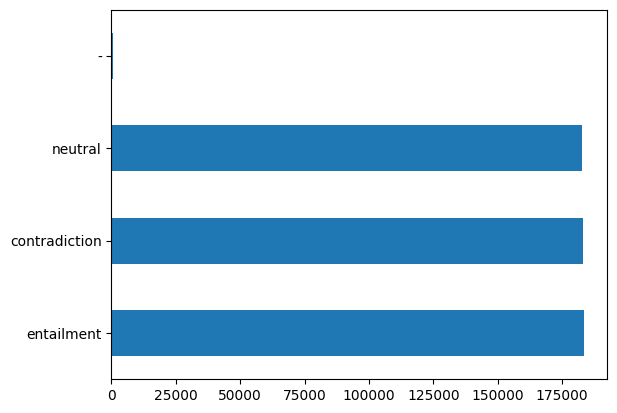

In [2]:
# https://www.kdnuggets.com/fine-tuning-llamav2-with-qlora-on-google-colab-for-free
import pandas as pd


#df = pd.read_csv('snli_1.0_train_matched.csv', sep='\t')
#df = pd.read_csv('./sp-data/firstfinetuning/snli_1.0_train.txt', sep='\t')
df = pd.read_csv('./drive/MyDrive/AAAMachineLearning/Projects/FineTuning/data/snli_1.0_train.txt', sep='\t')
df['gold_label'].value_counts().plot(kind='barh')

In [3]:
df[df['gold_label'] == 'contradiction'].sample(10)[['sentence1', 'sentence2']]

,sentence1,sentence2
58856,A woman wearing a blue scarf and sunglasses is...,The woman is not wearing sunglasses
304357,A man on a three-wheeled motorcycle driving do...,A man is driving by the exhibition hall in a s...
213966,A girl jumping in front of a jukebox mural.,A boy jumping in front of a jukebox mural.
428945,Two women are laughing on the floor with toy w...,The women are not laughing.
326919,Dark-haired man singing into a microphone and ...,A man is juggling knives on stage.
285783,A blond woman taking a photo of her young son ...,A woman is taking a photo of her cat.
324228,A lacrosse player tumbles in mid-game while ot...,A football player practices with his team.
410833,"Child standing on a public bus, looking outsid...",The bus driver is dead.
532803,"A slender man, shirtless with tattoos, carries...",A man is bouncing with excitement about some g...
130057,A farmhand in training points over the barrier...,The farmhand is sitting on his couch.


In [4]:
def convert_to_format(row):
    sentence1 = row['sentence1']
    sentence2 = row['sentence2']
    prompt = """Below is an instruction that describes a task paired with input that provides further context. Write a response that appropriately completes the request."""
    instruction = """Given the following sentence, your job is to generate the negation for it in the json format"""
    input = str(sentence1)
    response = f"""```json
{{'orignal_sentence': '{sentence1}', 'generated_negation': '{sentence2}'}}
```
"""
    if len(input.strip()) == 0:  #  prompt + 2 new lines + ###instruction + new line + input + new line + ###response
        text = prompt + "\n\n### Instruction:\n" + instruction + "\n### Response:\n" + response
    else:
        text = prompt + "\n\n### Instruction:\n" + instruction + "\n### Input:\n" + input + "\n" + "\n### Response:\n" + response

    # we need 4 columns for auto train, instruction, input, output, text
    return pd.Series([instruction, input, response, text])

new_df = df[df['gold_label'] == 'contradiction'][['sentence1', 'sentence2']].apply(convert_to_format, axis=1)
new_df.columns = ['instruction', 'input', 'output', 'text']

new_df.to_csv('snli_instruct.csv', index=False)

In [6]:
!pip install -q accelerate==0.21.0 peft==0.4.0 bitsandbytes==0.40.2 transformers==4.31.0 trl==0.4.7

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.9/72.9 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.5/92.5 MB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 112.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.4/77.4 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 83.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 36.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 118.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.7/493.7 kB 53.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.7 MB/s eta 0:00:00


In [7]:
import os
import torch
from datasets import load_dataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    HfArgumentParser,
    TrainingArguments,
    pipeline,
    logging,
)
from peft import LoraConfig, PeftModel
from trl import SFTTrainer

In [12]:
from google.colab import drive
import pandas as pd

#drive.mount('/content/drive')
#df = pd.read_csv('/content/drive/MyDrive/snli_instruct.csv')

#df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/snli_instruct.csv')
df = pd.read_csv('./snli_instruct.csv')

In [13]:
from datasets import Dataset

dataset = Dataset.from_pandas(df)

In [15]:
# The model that you want to train from the Hugging Face hub
model_name = "abhishek/llama-2-7b-hf-small-shards"

# Fine-tuned model name
new_model = "llama-2-contradictor"

################################################################################
# QLoRA parameters
################################################################################

# LoRA attention dimension
lora_r = 64

# Alpha parameter for LoRA scaling
lora_alpha = 16

# Dropout probability for LoRA layers
lora_dropout = 0.1

################################################################################
# bitsandbytes parameters
################################################################################

# Activate 4-bit precision base model loading
use_4bit = True

# Compute dtype for 4-bit base models
bnb_4bit_compute_dtype = "float16"

# Quantization type (fp4 or nf4)
bnb_4bit_quant_type = "nf4"

# Activate nested quantization for 4-bit base models (double quantization)
use_nested_quant = False

################################################################################
# TrainingArguments parameters
################################################################################

# Output directory where the model predictions and checkpoints will be stored
output_dir = "./results"

# Number of training epochs
num_train_epochs = 1

# Enable fp16/bf16 training (set bf16 to True with an A100)
fp16 = False
bf16 = False

# Batch size per GPU for training
per_device_train_batch_size = 4

# Batch size per GPU for evaluation
per_device_eval_batch_size = 4

# Number of update steps to accumulate the gradients for
gradient_accumulation_steps = 1

# Enable gradient checkpointing
gradient_checkpointing = True

# Maximum gradient normal (gradient clipping)
max_grad_norm = 0.3

# Initial learning rate (AdamW optimizer)
learning_rate = 1e-5

# Weight decay to apply to all layers except bias/LayerNorm weights
weight_decay = 0.001

# Optimizer to use
optim = "paged_adamw_32bit"

# Learning rate schedule
lr_scheduler_type = "cosine"

# Number of training steps (overrides num_train_epochs)
max_steps = -1

# Ratio of steps for a linear warmup (from 0 to learning rate)
warmup_ratio = 0.03

# Group sequences into batches with same length
# Saves memory and speeds up training considerably
group_by_length = True

# Save checkpoint every X updates steps
save_steps = 0

# Log every X updates steps
logging_steps = 100

################################################################################
# SFT parameters
################################################################################

# Maximum sequence length to use
max_seq_length = None

# Pack multiple short examples in the same input sequence to increase efficiency
packing = False

# Load the entire model on the GPU 0
device_map = {"": 0}

In [16]:
compute_dtype = getattr(torch, bnb_4bit_compute_dtype)

bnb_config = BitsAndBytesConfig(
    load_in_4bit=use_4bit,
    bnb_4bit_quant_type=bnb_4bit_quant_type,
    bnb_4bit_compute_dtype=compute_dtype,
    bnb_4bit_use_double_quant=use_nested_quant,
)

In [17]:
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map=device_map
)
model.config.use_cache = False
model.config.pretraining_tp = 1

(…)hards/resolve/main/tokenizer_config.json:   0%|          | 0.00/746 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

(…)small-shards/resolve/main/tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

(…)ll-shards/resolve/main/added_tokens.json:   0%|          | 0.00/21.0 [00:00<?, ?B/s]

(…)rds/resolve/main/special_tokens_map.json:   0%|          | 0.00/435 [00:00<?, ?B/s]

(…)hf-small-shards/resolve/main/config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

(…)esolve/main/pytorch_model.bin.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

pytorch_model-00001-of-00010.bin:   0%|          | 0.00/2.95G [00:00<?, ?B/s]

pytorch_model-00002-of-00010.bin:   0%|          | 0.00/2.88G [00:00<?, ?B/s]

pytorch_model-00003-of-00010.bin:   0%|          | 0.00/2.99G [00:00<?, ?B/s]

pytorch_model-00004-of-00010.bin:   0%|          | 0.00/2.86G [00:00<?, ?B/s]

pytorch_model-00005-of-00010.bin:   0%|          | 0.00/2.88G [00:00<?, ?B/s]

pytorch_model-00006-of-00010.bin:   0%|          | 0.00/2.97G [00:00<?, ?B/s]

pytorch_model-00007-of-00010.bin:   0%|          | 0.00/2.88G [00:00<?, ?B/s]

pytorch_model-00008-of-00010.bin:   0%|          | 0.00/2.99G [00:00<?, ?B/s]

pytorch_model-00009-of-00010.bin:   0%|          | 0.00/2.86G [00:00<?, ?B/s]

pytorch_model-00010-of-00010.bin:   0%|          | 0.00/705M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/10 [00:00<?, ?it/s]

(…)ards/resolve/main/generation_config.json:   0%|          | 0.00/174 [00:00<?, ?B/s]

In [18]:
# Load LoRA configuration
peft_config = LoraConfig(
    lora_alpha=lora_alpha,
    lora_dropout=lora_dropout,
    r=lora_r,
    bias="none",
    task_type="CAUSAL_LM",
)

# Set training parameters
training_arguments = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=num_train_epochs,
    per_device_train_batch_size=per_device_train_batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    optim=optim,
    save_steps=save_steps,
    logging_steps=logging_steps,
    learning_rate=learning_rate,
    weight_decay=weight_decay,
    fp16=fp16,
    bf16=bf16,
    max_grad_norm=max_grad_norm,
    max_steps=max_steps,
    warmup_ratio=warmup_ratio,
    group_by_length=group_by_length,
    lr_scheduler_type=lr_scheduler_type,
    report_to="tensorboard"
)

In [ ]:
# Set supervised fine-tuning parameters
trainer = SFTTrainer(
    model=model,
    train_dataset=dataset,
    peft_config=peft_config,
    dataset_text_field="text",  # this is the text column in dataset
    max_seq_length=max_seq_length,
    tokenizer=tokenizer,
    args=training_arguments,
    packing=packing,
)

# Train model
trainer.train()

# Save trained model
trainer.model.save_pretrained(new_model)

/usr/local/lib/python3.10/dist-packages/peft/utils/other.py:102: FutureWarning: prepare_model_for_int8_training is deprecated and will be removed in a future version. Use prepare_model_for_kbit_training instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:159: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(


Map:   0%|          | 0/183187 [00:00<?, ? examples/s]

You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss
100,2.414700
200,2.400300
300,2.320700
400,2.084100
500,1.684300
600,1.109200
700,0.709400
800,0.574100
900,0.545400
1000,0.531500


# New Section